# Purpose
The purpose of this notebook is to generate figure 4.

# Preliminaries

## load packages

In [1]:
%matplotlib inline
%autosave 60
%load_ext autoreload
%autoreload 2

#filesystem
import os
import glob
from pathlib import Path
from tqdm import tqdm

#plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from dateutil import rrule
import matplotlib.colors as mcolors

#data
import numpy as np
from datetime import datetime
from scipy.stats import pearsonr
import pandas as pd
import random
import ast
import pickle
import networkx as nx
import community
from datetime import datetime, timedelta
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.ndimage import gaussian_filter
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# custom modules
from src import parameters,rfid, plot
from src import timestamps
from src import spectrogramming
from src import preprocess
from src import cloudofmice as com


Autosaving every 60 seconds


## set paths

In [2]:
# The ID of the DAS model that generated the segments
DAS_model = '20230219_120047'

# main project root - to reproduce, just change root to the full path to mouse_barn_audiomoth on your computer
#root = '/path/to/proc_B_data_submission/'
root = '/Users/jourjine/Desktop/lindholm/barn_manuscript_final/public_repositories/wild-mus-vocal-ecology'

# this directory contains jpegs
pictures_root = os.path.join(root, 'parameters','images','barn_pictures')

# this directory contains raw vocalization segments
vocal_counts_path = os.path.join(root, 'data', 'segments', 'vocal_counts')

# path to dictionary recording which boxes were recorded when and with which audiomoth
boxes_dictionary = os.path.join(root, 'parameters', 'json_files', 'boxes_recorded.json')

# paths to dictionaries for coloring plots
vocalization_colors = os.path.join(root, 'parameters', 'json_files', 'vocalization_colors.json')
seasons_colors = os.path.join(root, 'parameters', 'json_files','season_color_dict.json')
audiomoth_colors = os.path.join(root, 'parameters', 'json_files','audiomoth_colors.json')

# paths to rfid reading directories (each contains a directory for meets, stays, and box events)
all_rfid = os.path.join(root, 'data', 'rfid') # path to rfid data from 2013-2023 ("all")

# path to adult phenotypes (with sex)
adult_sexes_path = os.path.join(root, 'data', 'phenotypes', 'sexes.csv')

# timestamp (string) of umap embedding to plot in yyyymmdd_hhmmss format
umap_ID = '20230707_111132'

# paths to vocal events data
vocal_events_path = os.path.join(root,'data', 'segments', 'vocal_events' )

# paths to example spectrograms
spectrograms_path = os.path.join(root,'data', 'umap', 'spectrograms' )


# Get the data

## Vocal events

In [3]:
#vocal events - all recordings
print('getting vocal events 2022-2023...')
v_events = pd.concat([pd.read_csv(i) for i in glob.glob(os.path.join(vocal_events_path, '*segments.csv'))])
v_events = preprocess.raw_data_from_cloud_of_mice(v_events, df_type='vocal_events')

#vocal counts - all recordings
print('getting vocal counts 2022-2023...')
v_counts = pd.concat([pd.read_csv(i) for i in glob.glob(os.path.join(vocal_counts_path, '*counts.csv'))])
v_counts = preprocess.raw_data_from_cloud_of_mice(v_counts, df_type='vocal_counts')

print('Done.')

getting vocal events 2022-2023...
Preprocessing a vocal_events table with 1366171 rows...
	...additing columns for year, month, day, and hour
		...done.
	...adding column for 'hour_start'
		...done.
	...adding season
		..done.
getting vocal counts 2022-2023...
Preprocessing a vocal_counts table with 401056 rows...
	...additing columns for year, month, day, and hour
		...done.
	...adding 'sunchange' column to indicate sunset (-1) and sunrise (1)
		...done.
	...adding column to count all vocalizations (squeak or USV)
		...done.
	...adding column for 'hour_start'
		...done.
	...adding season
		..done.
Done.


## Organize the raw data

### Percent vocal events by season

In [4]:
# Grouping v_events by deployment and getting the first occurrence of yearless_season for each deployment
v_events['yearless_season'] = [i.split('_')[0] for i in v_events['season']]
v_events = v_events[v_events['label'] != 'noise']
v_events_by_deployment = v_events[['deployment', 'yearless_season']].groupby('deployment').agg({'yearless_season':'first'}).reset_index()

# Counting the number of deployments for each season
num_summer_deployments = len(v_events_by_deployment[v_events_by_deployment['yearless_season'] == 'summer'])
num_winter_deployments = len(v_events_by_deployment[v_events_by_deployment['yearless_season'] == 'winter'])
num_autumn_deployments = len(v_events_by_deployment[v_events_by_deployment['yearless_season'] == 'autumn'])
num_spring_deployments = len(v_events_by_deployment[v_events_by_deployment['yearless_season'] == 'spring'])

# Printing the counts for each season
print(f'Number of summer deployments: {num_summer_deployments}')
print(f'Number of winter deployments: {num_winter_deployments}')
print(f'Number of autumn deployments: {num_autumn_deployments}')
print(f'Number of spring deployments: {num_spring_deployments}')


Number of summer deployments: 10
Number of winter deployments: 7
Number of autumn deployments: 11
Number of spring deployments: 8


In [5]:
#average detected vocalizations per box
summer_vocs = v_events[v_events['yearless_season'] == 'summer']
winter_vocs = v_events[v_events['yearless_season'] == 'winter']
autumn_vocs = v_events[v_events['yearless_season'] == 'autumn']
spring_vocs = v_events[v_events['yearless_season'] == 'spring']
total_vocs = len(v_events)
vocs_per_box = total_vocs/144
minutes_per_box = ((6594.3)*60)/144
vocs_per_minute_per_box = vocs_per_box/minutes_per_box
num_squeaks = len(v_events[v_events['label'] == 'squeak'])
num_USV = len(v_events[v_events['label'] == 'USV'])
print('There are', total_vocs, 'vocalizations, correspinding to', vocs_per_minute_per_box, "vocalizations per minute per box")
print(num_squeaks, 'of these are squeaks and', num_USV, "are USVs")
print(f"There are {num_squeaks/num_USV} times more squeaks than USVs\n\n")
print(len(summer_vocs)/total_vocs, "of vocalizations took place in summer.\n")
print(len(winter_vocs)/total_vocs, "of vocalizations took place in winter.\n")
print(len(autumn_vocs)/total_vocs, "of vocalizations took place in autumn.\n")
print(len(spring_vocs)/total_vocs, "of vocalizations took place in spring.\n")
print((len(spring_vocs)+len(summer_vocs))/total_vocs, "of vocalizations took place in spring and summer.\n")



There are 1366171 vocalizations, correspinding to 3.4529088252986164 vocalizations per minute per box
1260452 of these are squeaks and 105719 are USVs
There are 11.922662908275711 times more squeaks than USVs


0.5638745076568014 of vocalizations took place in summer.

0.024527676257218165 of vocalizations took place in winter.

0.058516832812290705 of vocalizations took place in autumn.

0.35308098327368975 of vocalizations took place in spring.

0.9169554909304911 of vocalizations took place in spring and summer.



In [6]:
# total vocalizations, squeaks, and USVs
print(f"Total vocalization: {len(v_events)}")
print(f"Total squeaks: {len(v_events[v_events['label'] == 'squeak'])}")
print(f"Total vocalization: {len(v_events[v_events['label'] == 'USV'])}")

Total vocalization: 1366171
Total squeaks: 1260452
Total vocalization: 105719


In [7]:
#average detected vocalizations per box
vocs_per_box = 1366171/144
minutes_per_box = ((6594.3)*60)/144
vocs_per_minute_per_box = vocs_per_box/minutes_per_box
print('Average vocalizations per box:', vocs_per_minute_per_box)

Average vocalizations per box: 3.4529088252986164


### Get vocalization counts by time of day

In [8]:
all_seasons = []   
for season in v_events['season'].unique():
    
    df = timestamps.get_vocalizations_by_hour_of_day(season = season, 
                                                     v_events = v_events)
    df['season'] = season
    all_seasons.append(df)
    
vocs_by_time_of_day = pd.concat(all_seasons)

/Users/jourjine/Desktop/lindholm/barn_manuscript_final/public_repositories/wild-mus-vocal-ecology/src/timestamps.py:970: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['audiomoth_start_seconds'].dt.date
/Users/jourjine/Desktop/lindholm/barn_manuscript_final/public_repositories/wild-mus-vocal-ecology/src/timestamps.py:971: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['combined_time'] = df['audiomoth_start_seconds'].dt.hour * 60 + df['audiomoth_start_seconds'].dt.minute
/Users/jourjine/Desk

/Users/jourjine/Desktop/lindholm/barn_manuscript_final/public_repositories/wild-mus-vocal-ecology/src/timestamps.py:970: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['audiomoth_start_seconds'].dt.date
/Users/jourjine/Desktop/lindholm/barn_manuscript_final/public_repositories/wild-mus-vocal-ecology/src/timestamps.py:971: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['combined_time'] = df['audiomoth_start_seconds'].dt.hour * 60 + df['audiomoth_start_seconds'].dt.minute
/Users/jourjine/Desk

### Calculate squeak--USV co-occurance

In [9]:
# Step 0
df = v_counts

# Step 1: Filter the DataFrame
filtered_df = df

# Step 2: Calculate Observed Overlap
observed_overlap = len(filtered_df[(filtered_df['squeak_count'] > 0) & (filtered_df['USV_count'] > 0)])/len(filtered_df)

# Step 3: Simulate Expected Overlap
n_permutations = 1000  # Number of permutations
expected_overlaps = []

for _ in tqdm(range(n_permutations)):
    shuffled_squeak_count = np.random.permutation(filtered_df['squeak_count'])
    shuffled_USV_count = np.random.permutation(filtered_df['USV_count'])
    expected_overlap = len(filtered_df[(shuffled_squeak_count > 0) & (shuffled_USV_count > 0)])
    expected_overlaps.append(expected_overlap/len(filtered_df))

# Step 4: Compare Observed to Expected
expected_overlaps = np.array(expected_overlaps)

p_value_right = (np.sum(expected_overlaps >= observed_overlap) + 1) / (n_permutations + 1)
p_value_left = (np.sum(expected_overlaps <= observed_overlap) + 1) / (n_permutations + 1)
p_value_two_tailed = 2 * min(p_value_right, p_value_left)

print(f'Observed overlap: {observed_overlap}')
print(f'Mean expected overlap: {np.mean(expected_overlaps)}')
print(f'P-value (right tail): {p_value_right}')
print(f'P-value (left tail): {p_value_left}')
print(f'P-value (two-tailed): {p_value_two_tailed}')



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.96it/s]

Observed overlap: 0.0241911354025373
Mean expected overlap: 0.007744434692412032
P-value (right tail): 0.000999000999000999
P-value (left tail): 1.0
P-value (two-tailed): 0.001998001998001998


## Make the Figure

/Users/jourjine/miniconda3/envs/test_audiomoth_env_20250225/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.canvas.draw()
/Users/jourjine/miniconda3/envs/test_audiomoth_env_20250225/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.canvas.draw()
/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_19234/2033917305.py:259: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  season_annotation_df_numeric = season_annotation_df.applymap(lambda x: list(season_colormap.keys()).index(x))


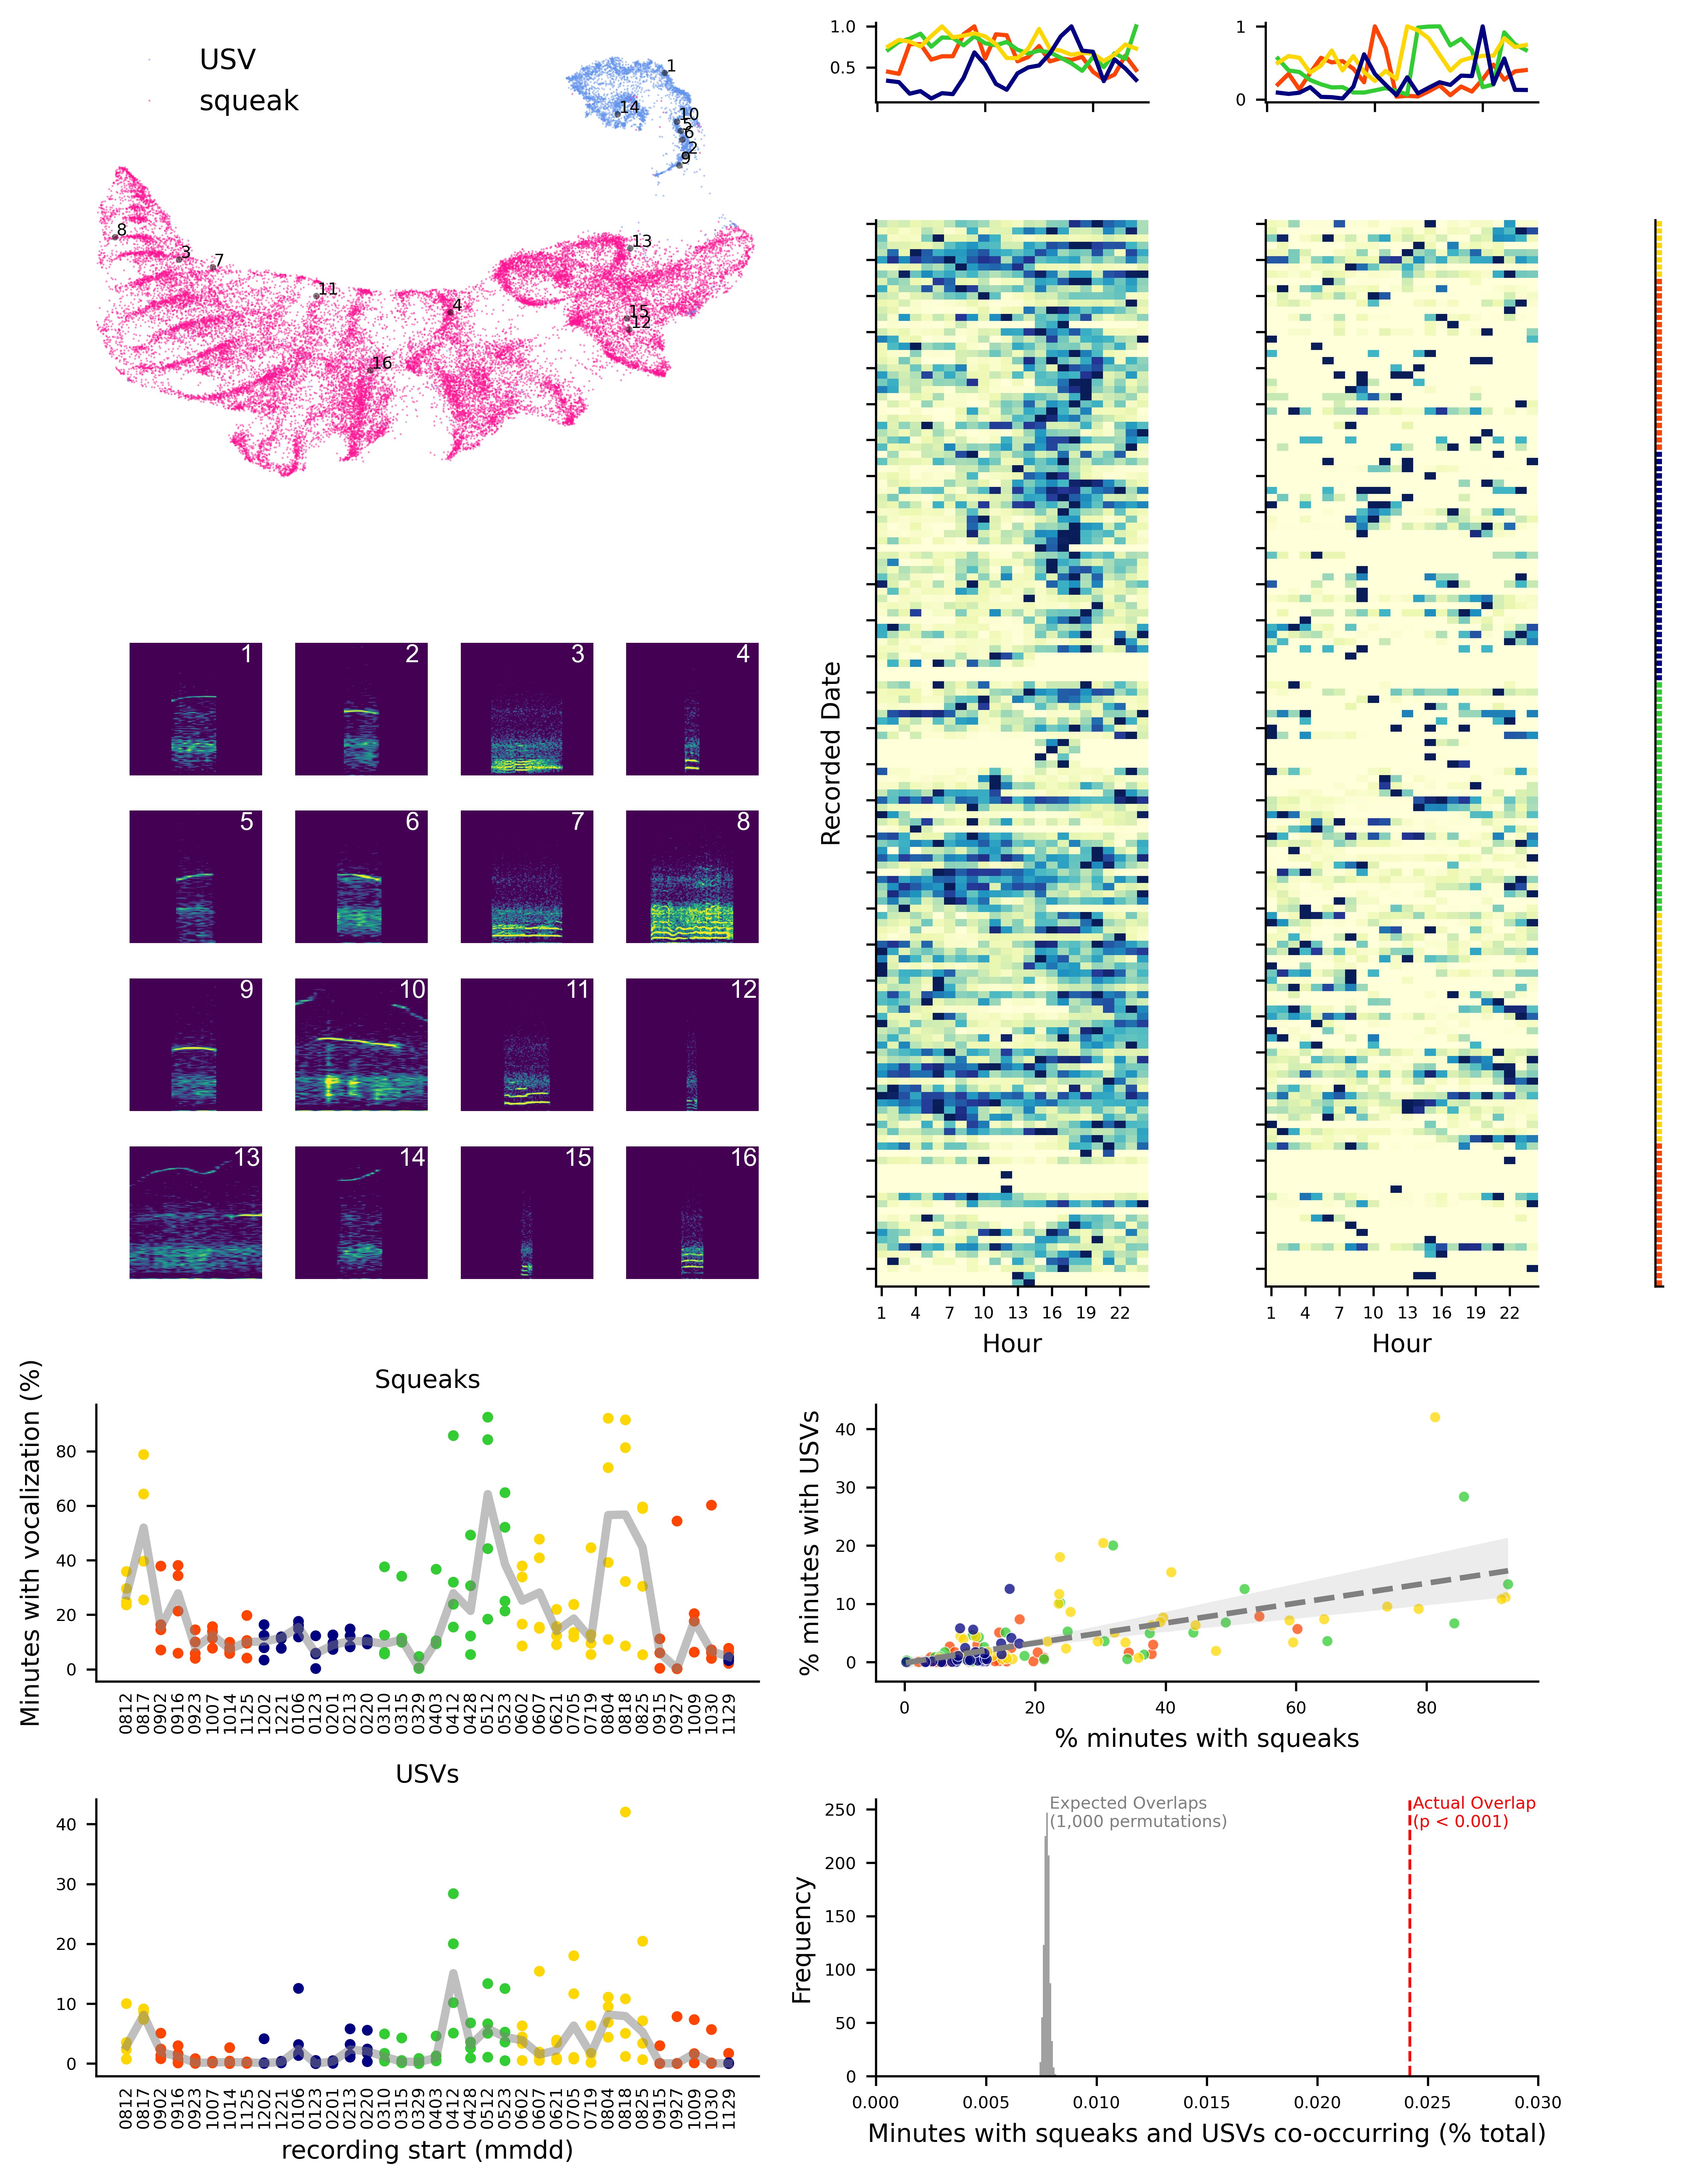

In [10]:
# save or not
save = False
path_to_save = '/Users/jourjine/Desktop/lindholm/barn_manuscript_final/procB_resubmission/resubmission_figures'

##################################################################################################
#root = '/path/to/proc_B_data_submission/'
root = '/Users/jourjine/Desktop/lindholm/barn_manuscript_final/public_repositories/wild-mus-vocal-ecology/'
umap_df = pd.read_feather(os.path.join(root, 'data/umap/20230707_111132_UMAPembedding_withfeatures.feather'))

##################################################################################################

# plotting parameters
plt.style.use('default')
tick_label_fontsize = 6
axis_label_fontsize = 9
title_label_fontsize = 12
num_ticks = 40 # for panel F x-axis
dot_size = .5
dot_alpha = .5
voc_colormap = parameters.load_json(vocalization_colors)
season_colormap = parameters.load_json(seasons_colors)

fig, axes = plt.subplot_mosaic(mosaic="EEEEIIJJ.;"\
                                      "EEEELLMMk;"\
                                      "EEEELLMMk;"\
                                      "FFFFLLMMk;"\
                                      "FFFFLLMMk;"
                                      "FFFFLLMMk;"\
                                      "FFFFLLMMk;"\
                                      "OOOORRRR.;"\
                                      "OOOORRRR.;"\
                                      "PPPPQQQQ.;"\
                                      "PPPPQQQQ.",

                               figsize=[8.5,11], 
                               gridspec_kw={'height_ratios': [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5, 0.5, 0.5], 
                                            'width_ratios':[1,1,1,1,1,1, 1, 1, 0.1]},
                               tight_layout=True,
                               dpi=600)

##################################################################################################
### PANELS E - UMAP embedding
##################################################################################################
embedding = umap_df
sns.scatterplot(data = embedding,
                x = 'umap1',
                y = 'umap2',
                hue = embedding['label'],
                palette = voc_colormap,
                s = dot_size,
                alpha = dot_alpha, 
                ax = axes["E"], 
                linewidth = 0,
                legend = 'brief')

axes["E"].set_xlim([-2.5,12.5])
axes["E"].set_ylim([-2.5,12.5])
axes["E"].legend(frameon=False)
axes["E"].axis('off')

#################################################################################################
## PANELS F - example spectrograms - NB this requires access to raw audio
#################################################################################################

num_freq_bins = 1024
num_time_bins = 1024
spec_min_val = 1.5
spec_max_val = 4.5
nperseg = 512
fs = 192000

squeak_spec_params = {
    'fs':fs,
    'nperseg':nperseg,
    'noverlap':nperseg//4,
    'num_freq_bins':num_freq_bins,
    'num_time_bins':num_time_bins,
    'min_freq':0,
    'max_freq':96000,
    'fill_value':spec_min_val,
    'max_duration':0.25,
    'spec_min_val':spec_min_val,
    'spec_max_val':spec_max_val
}

USV_spec_params = {
    'fs':fs,
    'nperseg':nperseg,
    'noverlap':nperseg//4,
    'num_freq_bins':num_freq_bins,
    'num_time_bins':num_time_bins,
    'min_freq':0,
    'max_freq':96000,
    'fill_value':spec_min_val,
    'max_duration':0.06,
    'spec_min_val':spec_min_val,
    'spec_max_val':spec_max_val
}

# Create a grid of square images within subplot F
axes["F"].axis('off')
num_rows, num_cols = 4, 4
image_size = 0.2 
inset_axes_dict = {}
inset_ID = 1
spacing = 0.02


for row in range(num_rows):
    for col in range(num_cols):
        x_pos = (col / num_cols) + 0.05
        y_pos = 1 - (row + 1) / num_rows
        inset_axes_dict[inset_ID] = axes['F'].inset_axes([x_pos, y_pos, image_size, image_size+spacing])
        inset_ID+=1

#the example USVs 
USV_names = ['audiomoth02_20220917_031100_clip1',
            'audiomoth03_20220903_094400_clip10',
            'audiomoth03_20220818_041700_clip5',
            'audiomoth03_20230107_083200_clip27',
            'audiomoth03_20220819_091300_clip11',
            'audiomoth03_20220903_094300_clip10',
            'audiomoth03_20220904_065600_clip4',
            'audiomoth03_20230107_192400_clip1']
USV_to_plot = embedding[embedding['clip_name'].isin(USV_names)]

# plot the spectrograms and decorate the UMAP
USV_txt = [1,2,5,6,9,10,13,14]
for USV_txt, umap1, umap2 in zip(USV_txt,USV_to_plot['umap1'], USV_to_plot['umap2']):
    voc = USV_to_plot[(USV_to_plot['umap1'] == umap1) & (USV_to_plot['umap2'] == umap2)] # one vocalization
    axes["E"].scatter(voc['umap1'],voc['umap2'],c = 'black',s = dot_size+5, linewidth=0,alpha = dot_alpha) #umap dot
    axes["E"].annotate(text=USV_txt, xy=(umap1,  umap2), xytext=(0.5,0.5), textcoords = 'offset points', color='black', fontsize=tick_label_fontsize) #umap dot number
    path_to_spec = os.path.join(root, 'data', 'umap', 'spectrograms', voc['clip_name'].iloc[0]+".npy")
    spec = np.load(path_to_spec)
    inset_axes_dict[int(USV_txt)].imshow(spec, origin='lower', extent = (num_freq_bins, 0, num_time_bins, 0 ), aspect='equal')
    inset_axes_dict[int(USV_txt)].text(118, 10, USV_txt, ha="center", va="top", color="w", fontsize=axis_label_fontsize, fontname='Arial')
    inset_axes_dict[int(USV_txt)].axis('off')

#the example squeaks
squeak_names = ['audiomoth01_20220818_074400_clip54',
                 'audiomoth01_20230317_035600_clip2',
                 'audiomoth02_20230311_165300_clip18',
                 'audiomoth01_20230317_035800_clip54',
                 'audiomoth01_20221126_183000_clip13',
                 'audiomoth01_20221015_165000_clip3',
                 'audiomoth01_20220818_064400_clip4',
                 'audiomoth01_20220818_012000_clip28']
squeaks_to_plot = embedding[embedding['clip_name'].isin(squeak_names)]  

# plot the spectrograms and decorate the UMAP
squeaks_txt = [3,4,7,8,11,12,15,16]
for squeaks_txt, umap1, umap2 in zip(squeaks_txt,squeaks_to_plot['umap1'], squeaks_to_plot['umap2']):
    voc = squeaks_to_plot[(squeaks_to_plot['umap1'] == umap1) & (squeaks_to_plot['umap2'] == umap2)] # one vocalization
    axes["E"].scatter(voc['umap1'],voc['umap2'],c = 'black',s = dot_size+5, linewidth=0,alpha = dot_alpha) #umap dot
    axes["E"].annotate(text=squeaks_txt, xy=(umap1,  umap2), xytext=(0.5,0.5), textcoords = 'offset points', color='black', fontsize=tick_label_fontsize) #umap dot number
    path_to_spec = os.path.join(root, 'data', 'umap', 'spectrograms', voc['clip_name'].iloc[0]+".npy")
    spec = np.load(path_to_spec)
    inset_axes_dict[int(squeaks_txt)].imshow(spec, origin='lower', extent = (num_freq_bins, 0, num_time_bins, 0 ), aspect='equal')
    inset_axes_dict[int(squeaks_txt)].text(118, 10, squeaks_txt, ha="center", va="top", color="w", fontsize=axis_label_fontsize, fontname='Arial')
    inset_axes_dict[int(squeaks_txt)].axis('off')

##################################################################################################
### PANEL & - vocal counts by time of day
##################################################################################################

season_colormap = parameters.load_json(seasons_colors)
season_order = ['summer_22', 'autumn_22', 'winter', 'spring', 'summer_23', 'autumn_23']

# Pivot the DataFrame to get hours as columns and dates as rows
USV_heatmap_data = vocs_by_time_of_day.pivot_table(
    index=['season', 'deployment', 'moth'],  # Rows represent each recorded day
    columns=['hour'],  # Columns represent each hour interval
    values='USV_count',  # Values to fill the heatmap
    fill_value=0  # Fill missing values with 0
)
# Convert 'season' index level to a categorical type with the defined order
USV_heatmap_data.index = pd.MultiIndex.from_frame(
    USV_heatmap_data.index.to_frame().assign(
        season=pd.Categorical(USV_heatmap_data.index.get_level_values('season'), categories=season_order, ordered=True)
    ),
    names=['season', 'deployment', 'moth']
)

# Sort the DataFrame by the new categorical index
USV_heatmap_data = USV_heatmap_data.sort_index()

# Define the desired order for seasons

# Pivot the DataFrame to get hours as columns and dates as rows
squeak_heatmap_data = vocs_by_time_of_day.pivot_table(
    index=['season', 'deployment', 'moth'],  # Rows represent each recorded day
    columns=['hour'],  # Columns represent each hour interval
    values='squeak_count',  # Values to fill the heatmap
    fill_value=0  # Fill missing values with 0
)
squeak_heatmap_data.index = pd.MultiIndex.from_frame(squeak_heatmap_data.index.to_frame().assign(
        season=pd.Categorical(squeak_heatmap_data.index.get_level_values('season'), categories=season_order, ordered=True)
    ),
    names=['season', 'deployment', 'moth']
)
squeak_heatmap_data = squeak_heatmap_data.sort_index()

# Normalize the rows to the maximum value in each row
USV_heatmap_data_normalized = USV_heatmap_data.div(USV_heatmap_data.max(axis=1), axis=0).fillna(0)
squeak_heatmap_data_normalized = squeak_heatmap_data.div(squeak_heatmap_data.max(axis=1), axis=0).fillna(0)

# Aggregate data for line plots
vocs_by_time_of_day['yearless_season'] = [i.split('_')[0] for i in vocs_by_time_of_day['season'] ]
lineplot_data = vocs_by_time_of_day.groupby(['hour', 'yearless_season'])[['USV_count', 'squeak_count']].sum().reset_index()
lineplot_data['USV_count'] = lineplot_data.groupby('yearless_season')['USV_count'].transform(lambda x: x / x.max())
lineplot_data['squeak_count'] = lineplot_data.groupby('yearless_season')['squeak_count'].transform(lambda x: x / x.max())

# Plot the lineplots using seaborn
sns.lineplot(data=lineplot_data, 
             x='hour', 
             y='USV_count', 
             hue='yearless_season', 
             palette=season_colormap, 
             ax=axes["J"], legend = False)
sns.lineplot(data=lineplot_data, 
             x='hour', 
             y='squeak_count', 
             hue='yearless_season', 
             palette=season_colormap, 
             ax=axes["I"], legend = False)

# Remove x-axis labels for lineplots
axes["J"].set_xticklabels([])
axes["I"].set_xticklabels([])
axes["J"].tick_params(axis = 'y', labelsize = tick_label_fontsize)
axes["I"].tick_params(axis = 'y', labelsize = tick_label_fontsize)

# Set y-axis labels for lineplots
axes["J"].set_ylabel('')
axes["I"].set_ylabel('')
axes["J"].set_xlabel('')
axes["I"].set_xlabel('')

# Plot the heatmaps
sns.heatmap(USV_heatmap_data_normalized, cmap='YlGnBu', annot=False, cbar=False, ax=axes["M"])
axes["M"].set_title('')
axes["M"].set_xlabel('Hour', fontsize = axis_label_fontsize)
axes["M"].set_ylabel('')
axes["M"].set_yticklabels([])
axes["M"].tick_params(axis = 'x', labelsize = tick_label_fontsize)

# Plot the heatmaps
sns.heatmap(squeak_heatmap_data_normalized, cmap='YlGnBu', annot=False, cbar=False, ax=axes["L"])
axes["L"].set_title('')
axes["L"].set_xlabel('Hour', fontsize = axis_label_fontsize)
axes["L"].set_ylabel('Recorded Date', fontsize = axis_label_fontsize)
axes["L"].set_yticklabels([])
axes["L"].tick_params(axis = 'x', labelsize = tick_label_fontsize)
axes["L"].tick_params(axis = 'y', labelsize = tick_label_fontsize)

# Convert the season names to numeric codes
season_annotation_df = pd.DataFrame(columns = ['season'])
season_annotation_df['season'] = squeak_heatmap_data.reset_index()['season']
season_annotation_df_numeric = season_annotation_df.applymap(lambda x: list(season_colormap.keys()).index(x))

# Create a color list from the colormap
colors = list(season_colormap.values())
cmap = mcolors.ListedColormap(colors)
bounds = list(range(len(season_colormap) + 1))
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the heatmap
sns.heatmap(
    season_annotation_df_numeric,
    cmap=cmap,
    annot=False,
    cbar=False,
    ax=axes['k'],
    linewidths=0.5,
    norm=norm
)

axes['k'].set_title('')
axes['k'].set_xlabel('')
axes['k'].set_ylabel('')
for ax in [axes['k']]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
sns.despine(ax = axes["J"])
sns.despine(ax = axes["I"])


##################################################################################################
### PANELS O and P - minutes with vocalization by deployment
##################################################################################################

#convert the "deployment" column to a categorical data type for regression
v_counts['deployment'] = pd.Categorical(v_counts['deployment'], ordered=True)
v_counts['deployment_codes'] = v_counts['deployment'].cat.codes

#calculate the percentage of minutes with > 1 vocalization counts for each value of "deployment"
contains_squeaks = v_counts.groupby(['season', 'deployment_codes', 'moth'])['squeak_count'].apply(lambda x: (x > 0).mean() * 100).reset_index().rename(columns = {'squeak_count':'percent_minutes_with_squeaks'})
contains_USVs = v_counts.groupby(['season','deployment_codes', 'moth'])['USV_count'].apply(lambda x: (x > 0).mean() * 100).reset_index().rename(columns = {'USV_count':'percent_minutes_with_USV'})
percent_minutes_with_vocs = contains_USVs.merge(contains_squeaks, on = ['season', 'deployment_codes', 'moth'])

# plot
sns.scatterplot(data=contains_squeaks, 
            x='deployment_codes', 
            y='percent_minutes_with_squeaks', 
            s=15,
            c = contains_squeaks['season'].map(season_colormap),
            linewidth=0,
            ax=axes["O"])
sns.scatterplot(data=contains_USVs, 
            x='deployment_codes', 
            y='percent_minutes_with_USV', 
            s=15,
            c = contains_USVs['season'].map(season_colormap),
            linewidth=0,
            ax=axes["P"])

mean_squeaks = contains_squeaks.groupby('deployment_codes')['percent_minutes_with_squeaks'].median().reset_index()
axes["O"].plot(mean_squeaks['deployment_codes'], 
               mean_squeaks['percent_minutes_with_squeaks'], 
               color='grey', 
               linestyle='-', 
               linewidth=3, 
               alpha = 0.5,
               marker='o', 
               markersize = 0)

mean_USVs = contains_USVs.groupby('deployment_codes')['percent_minutes_with_USV'].median().reset_index()
axes["P"].plot(mean_USVs['deployment_codes'], 
               mean_USVs['percent_minutes_with_USV'], 
               color='grey', 
               linestyle='-', 
               alpha = 0.5,
               linewidth=3, 
               marker='o', 
               markersize = 0)

# modify plots    
deployment_dates = [i[4:] for i in sorted([i.split('-')[0] for i in v_counts['deployment'].unique()])]
for ax in ["O", "P"]:
    axes[ax].set_xticks(range(len(deployment_dates)))
    axes[ax].set_xticklabels(deployment_dates, rotation=90, fontsize=6)
    axes[ax].tick_params(axis='x', length=0)
    axes[ax].tick_params(axis='y', labelsize=6)
    sns.despine(ax=axes[ax])

    if ax == "O":
        axes[ax].set_title('Squeaks', fontsize=axis_label_fontsize)
        axes[ax].set_xlabel('')
        axes[ax].set_ylabel('Minutes with vocalization (%)', fontsize=axis_label_fontsize)
    elif ax == "P":
        axes[ax].set_title('USVs', fontsize=9)
        axes[ax].set_xlabel('recording start (mmdd)', fontsize=axis_label_fontsize)
        axes[ax].set_ylabel('', fontsize=6)

##################################################################################################
### PANEL R minutes with squeak vs USV 
##################################################################################################
df = percent_minutes_with_vocs.copy()
df['yearless_season'] = [i.split('-')[0] for i in df['season']]

correlation, p_value = pearsonr(df['percent_minutes_with_squeaks'], df['percent_minutes_with_USV'])

sns.scatterplot(data = df, 
                x = 'percent_minutes_with_squeaks', 
                y = 'percent_minutes_with_USV', 
                ax = axes["R"], 
                hue = 'yearless_season', 
                palette = season_colormap,
                s = 15, alpha = 0.75,
                legend = False)
sns.regplot(data=df, 
            x='percent_minutes_with_squeaks', 
            y='percent_minutes_with_USV', 
            scatter=False, 
            color='grey', 
            line_kws={"linestyle":"--", "linewidth":2}, 
            ax = axes["R"])

sns.despine()

axes["R"].tick_params(axis = 'both', labelsize = tick_label_fontsize)
axes["R"].set_xlabel('% minutes with squeaks', fontsize = axis_label_fontsize)
axes["R"].set_ylabel('% minutes with USVs', fontsize = axis_label_fontsize)
sns.despine()

##################################################################################################
### PANEL Q squeak vs USV co-occurance
##################################################################################################

sns.histplot(expected_overlaps, 
             kde=False, 
             bins=10, 
             ax = axes["Q"], 
             linewidth = 0, 
             color = 'grey')
axes["Q"].axvline(observed_overlap, 
                  color='red', 
                  linestyle='dashed', 
                  linewidth=1)
axes["Q"].set_xlabel('Minutes with squeaks and USVs co-occurring (% total)', fontsize = axis_label_fontsize)
axes["Q"].set_ylabel('Frequency', fontsize = axis_label_fontsize)
axes["Q"].text(observed_overlap + axes["Q"].get_xlim()[1] * 0.005, 
               axes["Q"].get_ylim()[1] * 0.9, 
               'Actual Overlap\n(p < 0.001)', 
               fontsize=tick_label_fontsize, 
               color='red', 
               ha='left')

axes["Q"].text(np.mean(expected_overlaps) + axes["Q"].get_xlim()[1] * 0.005, 
               axes["Q"].get_ylim()[1] * 0.9, 
               'Expected Overlaps\n(1,000 permutations)', 
               fontsize=tick_label_fontsize, 
               color='grey', 
               ha='left')

axes["Q"].tick_params(axis = 'both', labelsize = tick_label_fontsize)
axes["Q"].set_xlim([0,0.03])
sns.despine()

#save
if save:
    plt.savefig(os.path.join(path_to_save, 'Figure4_revision_v1.svg'))
    plt.savefig(os.path.join(path_to_save, 'Figure4_revision_v1.jpeg'), dpi = 600)


In [11]:
import pickle

# Get the current rcParams
current_rc_params = plt.rcParams

# Convert rcParams to a dictionary (if not already) and save them to a file
with open('/Users/jourjine/Desktop/rc_params.pkl', 'wb') as file:
    pickle.dump(current_rc_params, file)
    
    

## Statistics

In [28]:
import statsmodels.stats.multicomp as multi
import statsmodels.stats.multitest as smm
from statsmodels.formula.api import ols
from docx import Document
from docx.shared import Inches
from src import modelselection
import scipy.stats as stats

In [34]:
resubmission_statistics = '/Users/jourjine/Desktop/lindholm/barn_manuscript_final/procB_resubmission/resubmission_statistics/figure_4'
save = True # if true, save statistics csvs and output to resubmission_statistics


### Panel C
minutes with squeaks ~ season

                       df        sum_sq      mean_sq          F        PR(>F)
C(yearless_season)    3.0  13063.860189  4354.620063  11.645337  7.438011e-07
Residual            139.0  51977.213770   373.936790        NaN           NaN
   group1  group2  meandiff   p-adj    lower    upper  reject
0  autumn  spring   13.4192  0.0198   1.5579  25.2805    True
1  autumn  summer   19.7895  0.0001   8.6142  30.9647    True
2  autumn  winter   -3.4681  0.8780 -15.5494   8.6132   False
3  spring  summer    6.3703  0.5084  -5.5558  18.2964   False
4  spring  winter  -16.8873  0.0043 -29.6663  -4.1083    True
5  summer  winter  -23.2576  0.0000 -35.4025 -11.1127    True


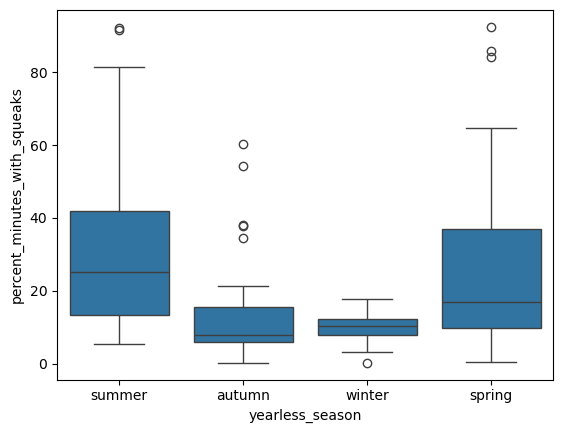

In [14]:
data = percent_minutes_with_vocs
dependent_var = 'percent_minutes_with_squeaks'
independent_var = 'yearless_season'
data['yearless_season'] = [i.split('_')[0] for i in data['season']]
independent_var = 'yearless_season'
data = data.dropna(subset = dependent_var)
analysis_name = 'figure4_panelC'

order = ['summer', 'autumn', 'winter', 'spring']
sns.boxplot(data = data, 
            x = 'yearless_season', 
            y = dependent_var, 
            order = order)

# Fit the one-way ANOVA model
formula = dependent_var + f" ~ C({independent_var})"
model = ols(formula, data=data).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)

# Perform Tukey's HSD post-hoc test
mc = multi.MultiComparison(data[dependent_var], data[independent_var])
tukey_result = mc.tukeyhsd()
tukey_result = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

# Print the results of the Tukey HSD test
print(tukey_result)

if save:
    
    #save the analysis results
    modelselection.save_ANOVA_tables_to_word(analysis_name+': '+formula, anova_table, tukey_result, os.path.join(resubmission_statistics, analysis_name +'.docx'))
    
    #save the data the analysis was run on
    data.to_csv(os.path.join(resubmission_statistics, analysis_name + '.csv'), index = False)

### Panel D
Percent minutes with USV ~ season

                       df       sum_sq     mean_sq         F    PR(>F)
C(yearless_season)    3.0   701.450658  233.816886  8.365094  0.000038
Residual            139.0  3885.258079   27.951497       NaN       NaN
   group1  group2  meandiff   p-adj   lower   upper  reject
0  autumn  spring    3.3942  0.0364  0.1513  6.6371    True
1  autumn  summer    5.2073  0.0001  2.1519  8.2626    True
2  autumn  winter    0.4013  0.9890 -2.9018  3.7043   False
3  spring  summer    1.8131  0.4731 -1.4475  5.0737   False
4  spring  winter   -2.9929  0.1209 -6.4867  0.5009   False
5  summer  winter   -4.8060  0.0014 -8.1265 -1.4856    True


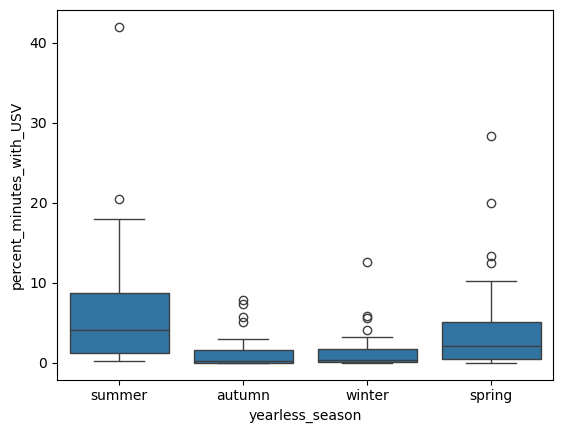

In [15]:
data = percent_minutes_with_vocs
dependent_var = 'percent_minutes_with_USV'
independent_var = 'yearless_season'

data['yearless_season'] = [i.split('_')[0] for i in data['season']]
independent_var = 'yearless_season'
data = data.dropna(subset = dependent_var)
analysis_name = 'figure4_panelD'

order = ['summer', 'autumn', 'winter', 'spring']
sns.boxplot(data = data, 
            x = 'yearless_season', 
            y = dependent_var, 
            order = order)

# Fit the one-way ANOVA model
formula = dependent_var + f" ~ C({independent_var})"
model = ols(formula, data=data).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)

# Perform Tukey's HSD post-hoc test
mc = multi.MultiComparison(data[dependent_var], data[independent_var])
tukey_result = mc.tukeyhsd()
tukey_result = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

# Print the results of the Tukey HSD test
print(tukey_result)

if save:
    
    #save the analysis results
    modelselection.save_ANOVA_tables_to_word(analysis_name+': '+formula, anova_table, tukey_result, os.path.join(resubmission_statistics, analysis_name +'.docx'))
    
    #save the data the analysis was run on
    data.to_csv(os.path.join(resubmission_statistics, analysis_name + '.csv'), index = False)

### Panel E
vocalizations ~ (time of day) * (season)

In [35]:
# squeaks
# Define the bins and labels 
# 1 = early morning (midnight to 6am)
# 2 = morning (6am to noon)
# 3 = afternoon (noon to 6pm)
# 4 = night
bins = [0, 6, 12, 18, 24]
labels = [1, 2, 3, 4]

# Use pd.cut to create the hour_interval column
vocs_by_time_of_day['hour_interval'] = pd.cut(vocs_by_time_of_day['hour'], bins=bins, labels=labels, right=True)
vocs_by_time_of_day['yearless_season'] = [i.split('_')[0] for i in vocs_by_time_of_day['season']]
dependent_var = 'squeak_count'
data = vocs_by_time_of_day.dropna(subset = [dependent_var])


for season in sorted(data['yearless_season'].unique()):
    print(season)
    analysis_name = 'figure4_panelE_squeak'+'_'+season
    this_season  = data[data['yearless_season'] == season] 
    formula = dependent_var + ' ~ C(hour_interval)'
    model = ols(formula, data=this_season).fit()
    anova_table = sm.stats.anova_lm(model)
    print(anova_table)
    p_value = anova_table['PR(>F)']['C(hour_interval)']
    
    if p_value < (0.05)/4:
        
        # Combine season and hour into a single factor
        this_season['group'] = this_season['yearless_season'].astype(str) + '-' + this_season['hour_interval'].astype(str)

        # Perform Tukey's HSD post-hoc test
        mc = multi.MultiComparison(this_season[dependent_var], this_season['group'])
        tukey_result = mc.tukeyhsd()
        tukey_df = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

        # Filter to just show comparisons within hours
        def is_same_hour(row):
            group1_hour = row['group1'].split('-')[1]
            group2_hour = row['group2'].split('-')[1]
            return group1_hour == group2_hour

        # Filter to just show comparisons within seasons
        def is_same_season(row):
            group1_season = row['group1'].split('-')[0]
            group2_season = row['group2'].split('-')[0]
            return group1_season == group2_season

        tukey_result = tukey_df[tukey_df.apply(is_same_season, axis=1)]
        print(tukey_result)
        
    else:
        
        tukey_result = pd.DataFrame()
        print('not significant\n')


    if save:

        #save the analysis results
        modelselection.save_ANOVA_tables_to_word(analysis_name+': '+formula, anova_table, tukey_result, os.path.join(resubmission_statistics, analysis_name +'.docx'))

        #save the data the analysis was run on
        data.to_csv(os.path.join(resubmission_statistics, analysis_name + '.csv'), index = False)

autumn
                       df        sum_sq      mean_sq         F    PR(>F)
C(hour_interval)      3.0  1.087228e+04  3624.094023  2.586137  0.051313
Residual          17084.0  2.394074e+07  1401.354375       NaN       NaN
not significant

Results saved to /Users/jourjine/Desktop/lindholm/barn_manuscript_final/procB_resubmission/resubmission_statistics/figure_4/figure4_panelE_squeak_autumn.docx
spring
                       df        sum_sq       mean_sq         F    PR(>F)
C(hour_interval)      3.0  1.506237e+05  50207.910255  1.183283  0.314388
Residual          16892.0  7.167447e+08  42431.012901       NaN       NaN
not significant

Results saved to /Users/jourjine/Desktop/lindholm/barn_manuscript_final/procB_resubmission/resubmission_statistics/figure_4/figure4_panelE_squeak_spring.docx
summer
                       df        sum_sq        mean_sq         F    PR(>F)
C(hour_interval)      3.0  1.885071e+05   62835.691993  0.627255  0.597315
Residual          19580.0  1.961441e+0

/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_19234/1823006619.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_season['group'] = this_season['yearless_season'].astype(str) + '-' + this_season['hour_interval'].astype(str)


     group1    group2  meandiff   p-adj   lower   upper  reject
0  winter-1  winter-2    0.5419  0.0986 -0.0641  1.1479   False
1  winter-1  winter-3    1.5329  0.0000  0.9269  2.1389    True
2  winter-1  winter-4    1.0476  0.0001  0.4416  1.6536    True
3  winter-2  winter-3    0.9910  0.0002  0.3850  1.5970    True
4  winter-2  winter-4    0.5057  0.1394 -0.1004  1.1117   False
5  winter-3  winter-4   -0.4853  0.1673 -1.0914  0.1207   False
Results saved to /Users/jourjine/Desktop/lindholm/barn_manuscript_final/procB_resubmission/resubmission_statistics/figure_4/figure4_panelE_squeak_winter.docx


autumn
                       df        sum_sq     mean_sq         F    PR(>F)
C(hour_interval)      3.0  5.506959e+02  183.565289  1.874566  0.131468
Residual          17084.0  1.672936e+06   97.924145       NaN       NaN
not significant
Results saved to /Users/jourjine/Desktop/lindholm/barn_manuscript_final/procB_resubmission/resubmission_statistics/figure_4/figure4_panelE_USV_autumn.docx
spring
                       df        sum_sq      mean_sq         F    PR(>F)
C(hour_interval)      3.0  2.142331e+04  7141.103595  4.908974  0.002071
Residual          16892.0  2.457286e+07  1454.703794       NaN       NaN


/var/folders/h6/6fyt3jld5pq_w03ql1jw0gnh0000gn/T/ipykernel_19234/2126308453.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_season['group'] = this_season['yearless_season'].astype(str) + '-' + this_season['hour_interval'].astype(str)


                       df        sum_sq      mean_sq         F    PR(>F)
C(hour_interval)      3.0  2.142331e+04  7141.103595  4.908974  0.002071
Residual          16892.0  2.457286e+07  1454.703794       NaN       NaN
     group1    group2  meandiff   p-adj   lower   upper  reject
0  spring-1  spring-2   -0.9406  0.6689 -3.0729  1.1917   False
1  spring-1  spring-3    2.0476  0.0652 -0.0847  4.1799   False
2  spring-1  spring-4    1.1020  0.5451 -1.0303  3.2344   False
3  spring-2  spring-3    2.9882  0.0018  0.8558  5.1205    True
4  spring-2  spring-4    2.0426  0.0662 -0.0897  4.1749   False
5  spring-3  spring-4   -0.9455  0.6651 -3.0779  1.1868   False
Results saved to /Users/jourjine/Desktop/lindholm/barn_manuscript_final/procB_resubmission/resubmission_statistics/figure_4/figure4_panelE_USV_spring.docx
summer
                       df        sum_sq      mean_sq         F    PR(>F)
C(hour_interval)      3.0  8.680052e+03  2893.350677  1.325515  0.264041
Residual          19580.0

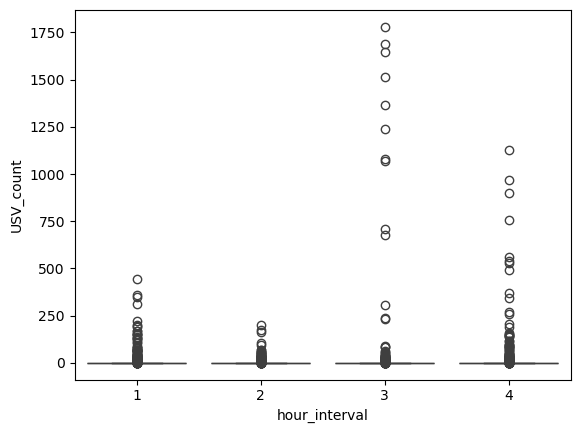

In [36]:
# USV
# Define the bins and labels 
# 1 = early morning (midnight to 6am)
# 2 = morning (6am to noon)
# 3 = afternoon (noon to 6pm)
# 4 = night (6pm to midnight)
bins = [0, 6, 12, 18, 24]
labels = [1, 2, 3, 4]

# Use pd.cut to create the hour_interval column
vocs_by_time_of_day['hour_interval'] = pd.cut(vocs_by_time_of_day['hour'], bins=bins, labels=labels, right=True)
vocs_by_time_of_day['yearless_season'] = [i.split('_')[0] for i in vocs_by_time_of_day['season']]
dependent_var = 'USV_count'
data = vocs_by_time_of_day.dropna(subset = [dependent_var])
analysis_name = 'figure4_panelE_USV'

for season in sorted(data['yearless_season'].unique()):
    print(season)
    analysis_name = 'figure4_panelE_USV'+'_'+season
    this_season  = data[data['yearless_season'] == season] 
    formula = dependent_var + ' ~ C(hour_interval)*C(hour_interval)'
    model = ols(formula, data=this_season).fit()
    anova_table = sm.stats.anova_lm(model)
    print(anova_table)
    p_value = anova_table['PR(>F)']['C(hour_interval)']
    
    if p_value < (0.05)/4: # bonferroni correction because were doing an ANOVA for each season
        
        # Combine season and hour into a single factor
        this_season['group'] = this_season['yearless_season'].astype(str) + '-' + this_season['hour_interval'].astype(str)

        # Perform Tukey's HSD post-hoc test
        mc = multi.MultiComparison(this_season[dependent_var], this_season['group'])
        tukey_result = mc.tukeyhsd()
        tukey_df = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

        # Filter to just show comparisons within hours
        def is_same_hour(row):
            group1_hour = row['group1'].split('-')[1]
            group2_hour = row['group2'].split('-')[1]
            return group1_hour == group2_hour

        # Filter to just show comparisons within seasons
        def is_same_season(row):
            group1_season = row['group1'].split('-')[0]
            group2_season = row['group2'].split('-')[0]
            return group1_season == group2_season

        tukey_result = tukey_df[tukey_df.apply(is_same_season, axis=1)]
        print(anova_table)
        print(tukey_result)
        
        sns.boxplot(data = this_season, x = 'hour_interval', y = 'USV_count')
        
    else:
        
        tukey_result = pd.DataFrame()
        print('not significant')

    if save:

        #save the analysis results
        modelselection.save_ANOVA_tables_to_word(analysis_name+': '+formula, anova_table, tukey_result, os.path.join(resubmission_statistics, analysis_name +'.docx'))

        #save the data the analysis was run on
        data.to_csv(os.path.join(resubmission_statistics, analysis_name + '.csv'), index = False)

### Panel F
Correlation between squaks and USVs

Pearson correlation coefficient: 0.6435099827194906
R^2: 0.41410509785963906
P-value: 4.416704746312393e-18


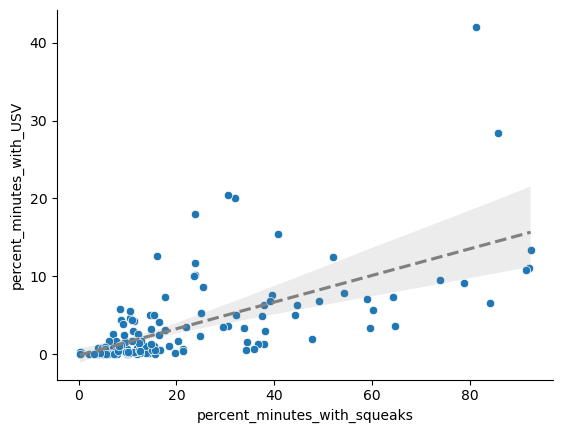

In [20]:
from scipy.stats import pearsonr

data = percent_minutes_with_vocs

# Calculate Pearson's correlation coefficient and p-value
correlation, p_value = pearsonr(data['percent_minutes_with_squeaks'], data['percent_minutes_with_USV'])

print(f'Pearson correlation coefficient: {correlation}')
print(f'R^2: {correlation**2}')
print(f'P-value: {p_value}')

sns.scatterplot(data = data, x = 'percent_minutes_with_squeaks', y = 'percent_minutes_with_USV')
sns.regplot(data=data, x='percent_minutes_with_squeaks', y='percent_minutes_with_USV', scatter=False, color='grey', line_kws={"linestyle":"--"})
sns.despine()



### Panel G
Squeak and USV co-occurance

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 117.65it/s]


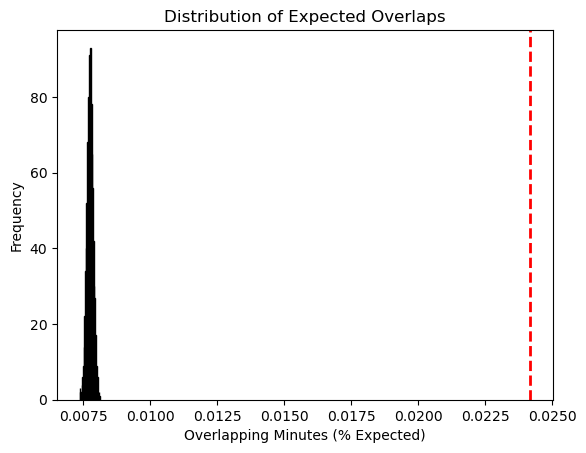

Observed overlap: 0.0241911354025373
Mean expected overlap: 0.0077462997686108676
P-value (right tail): 0.000999000999000999
P-value (left tail): 1.0
P-value (two-tailed): 0.001998001998001998
t-stat: 140.84427642237824


In [41]:
# Step 0
df = v_counts

# Step 1: Filter the DataFrame
#filtered_df = df[(df['squeak_count'] > 0) | (df['USV_count'] > 0)]
filtered_df = df

# Step 2: Calculate Observed Overlap
observed_overlap = len(filtered_df[(filtered_df['squeak_count'] > 0) & (filtered_df['USV_count'] > 0)])/len(filtered_df)

# Step 3: Simulate Expected Overlap
n_permutations = 1000  # Number of permutations
expected_overlaps = []

for _ in tqdm(range(n_permutations)):
    shuffled_squeak_count = np.random.permutation(filtered_df['squeak_count'])
    shuffled_USV_count = np.random.permutation(filtered_df['USV_count'])
    expected_overlap = len(filtered_df[(shuffled_squeak_count > 0) & (shuffled_USV_count > 0)])
    expected_overlaps.append(expected_overlap/len(filtered_df))

# Step 4: Compare Observed to Expected
expected_overlaps = np.array(expected_overlaps)
mean_expected_overlap = np.mean(expected_overlaps)
std_expected_overlap = np.std(expected_overlaps)

p_value_right = (np.sum(expected_overlaps >= observed_overlap) + 1) / (n_permutations + 1)
p_value_left = (np.sum(expected_overlaps <= observed_overlap) + 1) / (n_permutations + 1)
p_value_two_tailed = 2 * min(p_value_right, p_value_left)
t_stat = (observed_overlap - np.mean(expected_overlaps)) / std_expected_overlap

sns.histplot(expected_overlaps, kde=False, bins=30)
plt.axvline(observed_overlap, color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Overlapping Minutes (% Expected)')
plt.ylabel('Frequency')
plt.title('Distribution of Expected Overlaps')
plt.show()

print(f'Observed overlap: {observed_overlap}')
print(f'Mean expected overlap: {np.mean(expected_overlaps)}')
print(f'P-value (right tail): {p_value_right}')
print(f'P-value (left tail): {p_value_left}')
print(f'P-value (two-tailed): {p_value_two_tailed}')
print(f't-stat: {t_stat}')



### compare squeak and USV models with/without box as a random effect

In [22]:
from pymer4.models import Lmer
resubmission_statistics = '/Users/jourjine/Desktop/lindholm/barn_manuscript_final/procB_resubmission/RESUBMISSION_statistics/for_reviewers_only'


In [23]:
#convert the "deployment" column to a categorical data type for regression
v_counts['deployment'] = pd.Categorical(v_counts['deployment'], ordered=True)
v_counts['deployment_codes'] = v_counts['deployment'].cat.codes

In [24]:
data = v_counts.copy()

# Create the 'yearless_season' column
data['yearless_season'] = data['season'].str.split('_').str[0]
data = data.drop(columns = ['season']).rename(columns = {'yearless_season':'season'})

# Drop missing values
data = data.dropna(subset=['squeak_count'])

# Ensure 'box_number' is treated as a categorical variable
data['box'] = data['box'].astype('category')

# Define the fixed-effects-only GLM model (without 'box_number')
formula_fe = 'squeak_count ~ C(season)'
model_fe = smf.glm(formula=formula_fe, data=data, family=sm.families.Gaussian()).fit()

# Print the summary of the fixed-effects-only model
print(model_fe.summary2())
print("############################################################################################")
# Define the mixed-effects model (with 'box_number')
formula_me = 'squeak_count ~ C(season) + (1|box)'
model_me = Lmer(formula_me, data)
model_me.fit()
mixed_effects_summary = model_me.summary()
# Compare models using AIC or another suitable metric
print("Mixed-effects model summary:")
print(model_me.summary())

# extract tables from summary
table1_df, table2_df = pd.DataFrame(model_fe.summary2().tables[0]), pd.DataFrame(model_fe.summary2().tables[1])
tables = [table1_df, table2_df]

# save
fixed_analysis_name = 'fixed-mixed_effect_model_comparison'+formula_fe.replace(' ', '_')
mixed_analysis_name = 'fixed-mixed_effect_model_comparison'+formula_me.replace(' ', '_')

save = False
if save:
    #save the fixed effects summary table
    modelselection.save_glm_tables_to_word(formula_fe, tables, file_path=os.path.join(resubmission_statistics, fixed_analysis_name + '.docx'))
    
    
    #save the fixed effects summary table - delete the table1_df in word (doing it like this bc formatting is hard)
    modelselection.save_glm_tables_to_word(formula_me, [table1_df, mixed_effects_summary], file_path=os.path.join(resubmission_statistics, mixed_analysis_name + '.docx'))


                 Results: Generalized linear model
Model:                GLM              AIC:            3244163.4262
Link Function:        Identity         BIC:            3244207.0336
Dependent Variable:   squeak_count     Log-Likelihood: -1.6221e+06 
Date:                 2025-04-10 11:26 LL-Null:        -1.6288e+06 
No. Observations:     401056           Deviance:       7.6516e+07  
Df Model:             3                Pearson chi2:   7.65e+07    
Df Residuals:         401052           Scale:          190.79      
Method:               IRLS                                         
-------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------
Intercept            0.6784   0.0422 16.0941 0.0000  0.5958  0.7610
C(season)[T.spring]  4.1023   0.0618 66.4048 0.0000  3.9812  4.2234
C(season)[T.summer]  5.3870   0.0583 92.4193 0.0000  5.2728  5.50

/Users/jourjine/miniconda3/envs/test_audiomoth_env_20250225/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '
/Users/jourjine/miniconda3/envs/test_audiomoth_env_20250225/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "box". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
/Users/jourjine/miniconda3/envs/test_audiomoth_env_20250225/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: squeak_count~C(season)+(1|box)

Family: gaussian	 Inference: parametric

Number of observations: 401056	 Groups: {'box': 20.0}

Log-likelihood: -1614328.465 	 AIC: 3228668.930

Random effects:

                 Name      Var     Std
box       (Intercept)    7.858   2.803
Residual               183.490  13.546

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: squeak_count~C(season)+(1|box)

Family: gaussian	 Inference: parametric

Number of observations: 401056	 Groups: {'box': 20.0}

Log-likelihood: -1614328.465 	 AIC: 3228668.930

Random effects:

                 Name      Var     Std
box       (Intercept)    7.858   2.803
Residual               183.490  13.546

No random effect correlations specified

Fixed effects:

Mixed-effects model summary:
Linear mixed model fit by REML [’lmerMod’]
Formula: squeak_count~C(season)+(1|box)

Family: gaussian	 Inference: parametric

Numb

In [25]:
data = v_counts.copy()

# Create the 'yearless_season' column
data['yearless_season'] = data['season'].str.split('_').str[0]
data = data.drop(columns = ['season']).rename(columns = {'yearless_season':'season'})

# Drop missing values
data = data.dropna(subset=['USV_count'])

# Ensure 'box_number' is treated as a categorical variable
data['box'] = data['box'].astype('category')

# Define the fixed-effects-only GLM model (without 'box_number')
formula_fe = 'USV_count ~ C(season)'
model_fe = smf.glm(formula=formula_fe, data=data, family=sm.families.Gaussian()).fit()

# Print the summary of the fixed-effects-only model
print(model_fe.summary2())
print("############################################################################################")
# Define the mixed-effects model (with 'box_number')
formula_me = 'USV_count ~ C(season) + (1|box)'
model_me = Lmer(formula_me, data)
model_me.fit()
mixed_effects_summary = model_me.summary()
# Compare models using AIC or another suitable metric
print("Mixed-effects model summary:")
print(model_me.summary())

# extract tables from summary
table1_df, table2_df = pd.DataFrame(model_fe.summary2().tables[0]), pd.DataFrame(model_fe.summary2().tables[1])
tables = [table1_df, table2_df]

# save
fixed_analysis_name = 'fixed-mixed_effect_model_comparison'+formula_fe.replace(' ', '_')
mixed_analysis_name = 'fixed-mixed_effect_model_comparison'+formula_me.replace(' ', '_')

save = False
if save:
    #save the fixed effects summary table
    modelselection.save_glm_tables_to_word(formula_fe, tables, file_path=os.path.join(resubmission_statistics, fixed_analysis_name + '.docx'))
    
    
    #save the fixed effects summary table - delete the table1_df in word (doing it like this bc formatting is hard)
    modelselection.save_glm_tables_to_word(formula_me, [table1_df, mixed_effects_summary], file_path=os.path.join(resubmission_statistics, mixed_analysis_name + '.docx'))


                Results: Generalized linear model
Model:              GLM              AIC:            1905112.2839
Link Function:      Identity         BIC:            1905155.8913
Dependent Variable: USV_count        Log-Likelihood: -9.5255e+05 
Date:               2025-04-10 11:27 LL-Null:        -9.5354e+05 
No. Observations:   401056           Deviance:       2.7147e+06  
Df Model:           3                Pearson chi2:   2.71e+06    
Df Residuals:       401052           Scale:          6.7690      
Method:             IRLS                                         
-----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------
Intercept           0.0661   0.0079  8.3268 0.0000  0.0506 0.0817
C(season)[T.spring] 0.3100   0.0116 26.6442 0.0000  0.2872 0.3328
C(season)[T.summer] 0.4128   0.0110 37.5958 0.0000  0.3913 0.4343
C(season)[T.winter] 0.0196

/Users/jourjine/miniconda3/envs/test_audiomoth_env_20250225/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '
/Users/jourjine/miniconda3/envs/test_audiomoth_env_20250225/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "box". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
/Users/jourjine/miniconda3/envs/test_audiomoth_env_20250225/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: USV_count~C(season)+(1|box)

Family: gaussian	 Inference: parametric

Number of observations: 401056	 Groups: {'box': 20.0}

Log-likelihood: -950483.127 	 AIC: 1900978.255

Random effects:

                 Name    Var    Std
box       (Intercept)  0.071  0.266
Residual               6.697  2.588

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: USV_count~C(season)+(1|box)

Family: gaussian	 Inference: parametric

Number of observations: 401056	 Groups: {'box': 20.0}

Log-likelihood: -950483.127 	 AIC: 1900978.255

Random effects:

                 Name    Var    Std
box       (Intercept)  0.071  0.266
Residual               6.697  2.588

No random effect correlations specified

Fixed effects:

Mixed-effects model summary:
Linear mixed model fit by REML [’lmerMod’]
Formula: USV_count~C(season)+(1|box)

Family: gaussian	 Inference: parametric

Number of observations: 401056	 G

In [26]:
mixed_effects_summary

Estimate  2.5_ci  97.5_ci     SE          DF  T-stat  P-val  \
(Intercept)         0.075  -0.043    0.192  0.060      19.544   1.245  0.228   
C(season)spring     0.265   0.242    0.288  0.012  400398.594  22.266  0.000   
C(season)summer     0.397   0.375    0.419  0.011  400571.252  35.326  0.000   
C(season)winter    -0.022  -0.046    0.002  0.012  400591.859  -1.773  0.076   

                 Sig  
(Intercept)           
C(season)spring  ***  
C(season)summer  ***  
C(season)winter    .